Link: https://colab.research.google.com/drive/1a2No-gMQBfUT2mm3GIMOwRssg8Lu9S8P?usp=sharing

# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import NMF


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/BBC News Train.csv', sep=',', header=0)

# Data Overview
This is an overview of the data set. We have 3 columns: ArticleID, Text and Category.

In [ ]:
df.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Check if there is any missing data:

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)


ArticleId          0
Text               0
Category           0
predicted_label    0
dtype: int64


There is no missing data so we can proceed to the next steps.

# Data Visualization

Count of articles in each category: business, tech, politics, sport, entertainment. We can observe that the distribution is relatively even and there is no concern of imbalance classes that might impact our models later on.

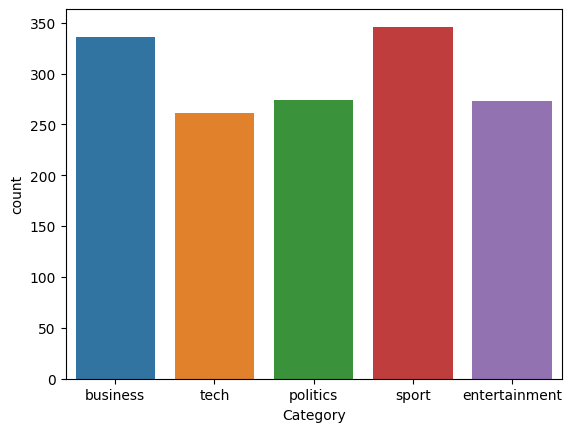

In [ ]:
sns.countplot(data=df, x='Category')
plt.show()

# Untuned NMF Model using 100% of Training data

### Text Preprocessing (Lemmatization)

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(text)

df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Text'])

### Model Building

In [ ]:
from sklearn.decomposition import NMF

n_topics = 5  # This should match with the number of unique categories

nmf = NMF(n_components=n_topics, random_state=1)
W = nmf.fit_transform(X)  # Topic matrix
H = nmf.components_  # Word matrix


In [ ]:
# Check the top words in each topic to assign labels
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic 0
game england win player team cup ireland match wale said
Topic 1
mr labour election blair party brown tory said tax would
Topic 2
mobile phone people music technology service said digital user microsoft
Topic 3
film best award actor oscar star actress director festival nomination
Topic 4
growth economy rate said bank year market economic sale dollar


In [ ]:
# Preprocess the text data
df['Text'] = df['Text'].apply(preprocess_text)

# Vectorize the text data
X_test = vectorizer.transform(df['Text'])


In [ ]:
# Apply NMF
W_test = nmf.transform(X_test)

# Assign the topic with the highest contribution as the label for each document in testing data
df['predicted_label'] = W_test.argmax(axis=1)

label_dict have to be mapped correctly according to the Topic results above.

In [ ]:
# Create a mapping dictionary
label_dict = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}

# Map the predicted labels to their corresponding categories
df['predicted_label'] = df['predicted_label'].map(label_dict)

Training accuracy:

In [ ]:
# Compute the accuracy score
accuracy = accuracy_score(df['Category'], df['predicted_label'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.9161073825503355


In [ ]:
df.head(5)

,ArticleId,Text,Category,predicted_label
0,1833,worldcom ex-boss launch defence lawyer defendi...,business,business
1,154,german business confidence slide german busine...,business,business
2,1101,bbc poll indicates economic gloom citizen majo...,business,business
3,1976,lifestyle governs mobile choice faster better ...,tech,tech
4,917,enron bos $168m payout eighteen former enron d...,business,business


### Predicting using Testing Data

In [ ]:
# Load the test data
df_test = pd.read_csv('/content/gdrive/MyDrive/BBC News Test.csv', sep=',', header=0)

In [ ]:
# Preprocess and Vectorize the test data
X_test = vectorizer.transform(df_test['Text'])

# Apply the NMF model
W_test = nmf.transform(X_test)


In [ ]:
# Print out the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 0
game england win player team cup ireland match wale said
Topic 1
mr labour election blair party brown tory said tax would
Topic 2
mobile phone people music technology service said digital user microsoft
Topic 3
film best award actor oscar star actress director festival nomination
Topic 4
growth economy rate said bank year market economic sale dollar


In [ ]:
# Get the topic that has the maximum value for each document
df_test['predicted_label'] = W_test.argmax(axis=1)

Similarly, the predicted labels has to be the same as the Topic results above.

In [ ]:
# Map the predicted labels to their respective categories
label_to_category = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
df_test['predicted_category'] = df_test['predicted_label'].map(label_to_category)


In [ ]:
# Drop 'Text' column
df_test = df_test.drop(['Text'], axis=1)

# Rename 'predicted_category' to 'Category'
df_test = df_test.rename(columns={'predicted_category': 'Category'})


In [ ]:
df_test.head(15)

,ArticleId,predicted_label,Category
0,1018,0,sport
1,1319,2,tech
2,1138,0,sport
3,459,4,business
4,1020,0,sport
5,51,0,sport
6,2025,1,politics
7,1479,1,politics
8,27,3,entertainment
9,397,4,business


In [ ]:
# Drop column
df_test = df_test.drop(['predicted_label'], axis=1)

In [ ]:
# Write DataFrame to csv
df_test.to_csv('BBC_News_Test_PredictionsNotTunedMF.csv', index=False)

In [ ]:
from google.colab import files
files.download('BBC_News_Test_PredictionsNotTunedMF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy score on the testing data set: 0.90204

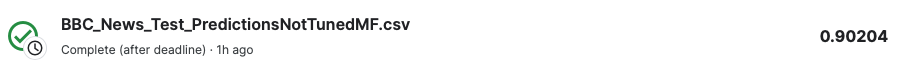

# Tuned NMF on 100% Training Data

In [ ]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_df=0.9, min_df=3, max_features=1500, ngram_range=(1, 3))
X_train = vectorizer.fit_transform(df['Text'])

# Apply NMF
n_topics = 5  # Increase the number of topics
nmf = NMF(n_components=n_topics, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=1000)
W_train = nmf.fit_transform(X_train)  # Topic matrix


In [ ]:

# Assign the topic with the highest contribution as the label for each document in training data
df['predicted_label'] = W_train.argmax(axis=1)

# Repeat the process for the validation set
X_val = vectorizer.transform(df['Text'])
W_val = nmf.transform(X_val)
df['predicted_label'] = W_val.argmax(axis=1)



In [ ]:
# Print out the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic 0
game england win club player said match team champion cup
Topic 1
mr said election labour government party blair would minister tory
Topic 2
film award best star show band actor music year oscar
Topic 3
said company firm market bank year growth share sale price
Topic 4
mobile people phone technology said service software computer mail user


In [ ]:
# Create a mapping dictionary for labels
label_dict = {0: 'sport', 1: 'politics', 2: 'entertainment', 3: 'business', 4: 'tech'}

# Map the numerical labels to their corresponding categories
df['predicted_label'] = df['predicted_label'].map(label_dict)

Training accuracy after model tuning:

In [ ]:
# Compute the accuracy score
accuracy = accuracy_score(df['Category'], df['predicted_label'])
print(f'Accuracy: {accuracy}')


Accuracy: 0.9536912751677852


In [ ]:
# Load the test data
df_test = pd.read_csv('/content/gdrive/MyDrive/BBC News Test.csv', sep=',', header=0)

In [ ]:
# Preprocess and Vectorize the test data
X_test = vectorizer.transform(df_test['Text'])

# Apply the NMF model
W_test = nmf.transform(X_test)


In [ ]:
# Print out the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 0
game england win club player said match team champion cup
Topic 1
mr said election labour government party blair would minister tory
Topic 2
film award best star show band actor music year oscar
Topic 3
said company firm market bank year growth share sale price
Topic 4
mobile people phone technology said service software computer mail user


In [ ]:
# Get the topic that has the maximum value for each document
df_test['predicted_label'] = W_test.argmax(axis=1)

In [ ]:
# Map the predicted labels to their respective categories
label_to_category = {0: 'sport', 1: 'politics', 2: 'entertainment', 3: 'business', 4: 'tech'}
df_test['predicted_category'] = df_test['predicted_label'].map(label_to_category)


In [ ]:
# Drop 'Text' column
df_test = df_test.drop(['Text'], axis=1)

# Rename 'predicted_category' to 'Category'
df_test = df_test.rename(columns={'predicted_category': 'Category'})


In [ ]:
df_test.head(15)

,ArticleId,predicted_label,Category
0,1018,0,sport
1,1319,4,tech
2,1138,0,sport
3,459,3,business
4,1020,0,sport
5,51,0,sport
6,2025,1,politics
7,1479,1,politics
8,27,2,entertainment
9,397,3,business


In [ ]:
# Drop column
df_test = df_test.drop(['predicted_label'], axis=1)

In [ ]:
# Write DataFrame to csv
df_test.to_csv('BBC_News_Test_PredictionsMF.csv', index=False)

In [ ]:
from google.colab import files
files.download('BBC_News_Test_PredictionsMF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy score of the tuned NMF model on the testing data: 0.88571. Even though the training accuracy increases sharply to 0.95, the testing accuracy decreases marginally 0.90240 to 0.88571. This can signal that the tuned model is actually overfitted leading to the worse outcome.

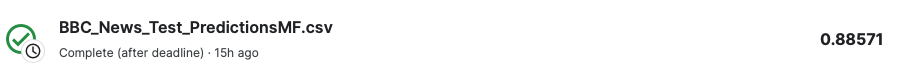

# Untuned NMF Model using 50% of Training data

### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Load the training data
df = pd.read_csv('/content/gdrive/MyDrive/BBC News Train.csv', sep=',', header=0)

# Split the data into training and validation sets
train_df, _ = train_test_split(df, test_size=0.5, random_state=42)

### Data Preprocessing

In [ ]:
# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(text)

In [ ]:
# Preprocess the text data
train_df['Text'] = train_df['Text'].apply(preprocess_text)

In [ ]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['Text'])

### Model Building

In [ ]:
# Define the number of topics
n_topics = 5

# Apply NMF
nmf = NMF(n_components=n_topics, random_state=1)
W_train = nmf.fit_transform(X_train)  # Topic matrix


In [ ]:
# Display top words in each topic to assign labels
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx + 1}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 1
england game ireland player win wale match first injury france
Topic 2
mr election labour blair brown party said tory tax would
Topic 3
mobile phone people technology service music broadband digital video said
Topic 4
film best award actor oscar festival star director actress comedy
Topic 5
said economy growth bank year company firm market economic rate


In [ ]:
# Apply the same preprocessing and vectorization to the validation set
X_val = vectorizer.transform(df['Text'])

# Transform the validation data using the trained NMF model
W_val = nmf.transform(X_val)


In [ ]:
# Assign the topic with the highest contribution as the label for each document in the validation set
df['predicted_label'] = W_val.argmax(axis=1)

# Create a mapping dictionary
label_dict = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}

# Map the predicted labels to their corresponding categories
df['predicted_label'] = df['predicted_label'].map(label_dict)

In [ ]:
# Compute the accuracy score
accuracy = accuracy_score(df['Category'], df['predicted_label'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.8973154362416107


### Predicting on Testing data

In [ ]:
# Load the test data
df_test = pd.read_csv('/content/gdrive/MyDrive/BBC News Test.csv', sep=',', header=0)

In [ ]:
# Preprocess and Vectorize the test data
X_test = vectorizer.transform(df_test['Text'])

# Apply the NMF model
W_test = nmf.transform(X_test)


In [ ]:
# Print out the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 0
england game ireland player win wale match first injury france
Topic 1
mr election labour blair brown party said tory tax would
Topic 2
mobile phone people technology service music broadband digital video said
Topic 3
film best award actor oscar festival star director actress comedy
Topic 4
said economy growth bank year company firm market economic rate


In [ ]:
# Get the topic that has the maximum value for each document
df_test['predicted_label'] = W_test.argmax(axis=1)

In [ ]:
# Map the predicted labels to their respective categories
label_to_category = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
df_test['predicted_category'] = df_test['predicted_label'].map(label_to_category)


In [ ]:
# Drop 'Text' column
df_test = df_test.drop(['Text'], axis=1)

# Rename 'predicted_category' to 'Category'
df_test = df_test.rename(columns={'predicted_category': 'Category'})


In [ ]:
df_test.head(15)

,ArticleId,predicted_label,Category
0,1018,0,sport
1,1319,2,tech
2,1138,0,sport
3,459,4,business
4,1020,0,sport
5,51,0,sport
6,2025,1,politics
7,1479,1,politics
8,27,3,entertainment
9,397,4,business


In [ ]:
# Drop column
df_test = df_test.drop(['predicted_label'], axis=1)

In [ ]:
# Write DataFrame to csv
df_test.to_csv('BBC_News_Test_PredictionsNotTunedMF50.csv', index=False)

In [ ]:
from google.colab import files
files.download('BBC_News_Test_PredictionsNotTunedMF50.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy score of the untuned NMF model using 50% of the training data. The score is approximately the same as the model using 100% of the training data. We can conclude that NMF models are generally data-efficient: they require a smaller amount of data to achieve similar results.

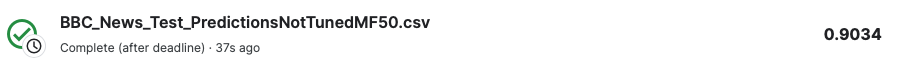

# Untuned XGBoost using 100% of Training Data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(df['Text'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert categories to numerical form
encoder = LabelEncoder()
y_train = encoder.fit_transform(df['Category'])


In [ ]:
from xgboost import XGBClassifier

# Create and train the model
model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score

# Vectorize the validation text
X_val = vectorizer.transform(df['Text'])

# Convert validation categories to numerical form
y_val = encoder.transform(df['Category'])

# Make predictions and evaluate the model
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 1.0


In [ ]:
df.head(15)

,ArticleId,Text,Category,predicted_label
0,1833,worldcom ex-boss launch defence lawyer defendi...,business,business
1,154,german business confidence slide german busine...,business,business
2,1101,bbc poll indicates economic gloom citizen majo...,business,business
3,1976,lifestyle governs mobile choice faster better ...,tech,tech
4,917,enron bos $168m payout eighteen former enron d...,business,business
5,1582,howard truanted play snooker conservative lead...,politics,politics
6,651,wale silent grand slam talk rhys williams say ...,sport,sport
7,1797,french honour director parker british film dir...,entertainment,entertainment
8,2034,car giant hit mercedes slump slump profitabili...,business,business
9,1866,fockers fuel festive film chart comedy meet fo...,entertainment,entertainment


In [ ]:
# Load the test data
df_test = pd.read_csv('/content/gdrive/MyDrive/BBC News Test.csv', sep=',', header=0)

In [ ]:
# Preprocess and Vectorize the test data
X_test = vectorizer.transform(df_test['Text'])

# Predict the labels
y_test_pred = model.predict(X_test)


In [ ]:
# Transform the numerical labels back to original categories
df_test['predicted_category'] = encoder.inverse_transform(y_test_pred)

# The predicted categories are now in the 'predicted_category' column
df_test.head(15)

,ArticleId,Text,predicted_category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
5,51,lewsey puzzle over disallowed try england s jo...,sport
6,2025,blair blasts tory spending plans tony blair ha...,politics
7,1479,former ni minister scott dies former northern ...,politics
8,27,career honour for actor dicaprio actor leonard...,entertainment
9,397,tsunami to hit sri lanka banks sri lanka s b...,business


In [ ]:
# Drop 'Text' column
df_test = df_test.drop(['Text'], axis=1)

# Rename 'predicted_category' to 'Category'
df_test = df_test.rename(columns={'predicted_category': 'Category'})


In [ ]:
df_test.head(15)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [ ]:
# Write DataFrame to csv
df_test.to_csv('BBC_News_Test_Predictions.csv', index=False)

In [ ]:
from google.colab import files
files.download('BBC_News_Test_Predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy Score of the Untuned XGBoost Model on 100% of the Training data: 0.95238

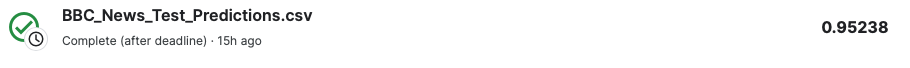

# Tuned XGBoost Model on 100% of the Training Data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1500)
X_train = vectorizer.fit_transform(df['Text'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert categories to numerical form
encoder = LabelEncoder()
y_train = encoder.fit_transform(df['Category'])

In [ ]:
from xgboost import XGBClassifier

# Create and train the model
model = XGBClassifier(learning_rate=0.001,max_depth=8,n_estimators=300)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score

# Vectorize the validation text
X_val = vectorizer.transform(df['Text'])

# Convert validation categories to numerical form
y_val = encoder.transform(df['Category'])

# Make predictions and evaluate the model
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9845637583892617


In [ ]:
# Load the test data
df_test = pd.read_csv('/content/gdrive/MyDrive/BBC News Test.csv', sep=',', header=0)

In [ ]:
# Preprocess and Vectorize the test data
X_test = vectorizer.transform(df_test['Text'])

# Predict the labels
y_test_pred = model.predict(X_test)


In [ ]:
# Transform the numerical labels back to original categories
df_test['predicted_category'] = encoder.inverse_transform(y_test_pred)

# The predicted categories are now in the 'predicted_category' column
df_test.head(15)

,ArticleId,Text,predicted_category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
5,51,lewsey puzzle over disallowed try england s jo...,sport
6,2025,blair blasts tory spending plans tony blair ha...,politics
7,1479,former ni minister scott dies former northern ...,politics
8,27,career honour for actor dicaprio actor leonard...,entertainment
9,397,tsunami to hit sri lanka banks sri lanka s b...,business


In [ ]:
# Drop 'Text' column
df_test = df_test.drop(['Text'], axis=1)

# Rename 'predicted_category' to 'Category'
df_test = df_test.rename(columns={'predicted_category': 'Category'})


In [ ]:
df_test.head(15)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [ ]:
# Write DataFrame to csv
df_test.to_csv('BBC_News_Test_Predictions3.csv', index=False)

In [ ]:
from google.colab import files
files.download('BBC_News_Test_Predictions3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using the tuned version of the XGBoost Model, the accuracy score on the testing data actually decreases to 0.88163. Overfitting of the model is likely the case here.

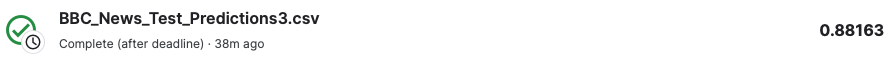

# Untuned XGBoost Model on 50% of the Training Data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load the data
df = pd.read_csv('/content/gdrive/MyDrive/BBC News Train.csv')

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Text'])

# Convert categories to numerical form
encoder = LabelEncoder()
y = encoder.fit_transform(df['Category'])

# Split the data into train and 'unused' sets
X_train, X_unused, y_train, y_unused = train_test_split(X, y, train_size=0.5, random_state=42)

# Create and train the model on 50% of the data
model = XGBClassifier()
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# Predict the training labels
y_train_pred = model.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 1.0


In [ ]:
# Load the test data
df_test = pd.read_csv('/content/gdrive/MyDrive/BBC News Test.csv')

# Preprocess and Vectorize the test data using the same vectorizer
X_test = vectorizer.transform(df_test['Text'])

# Use the model to predict the labels of the test set
y_test_pred = model.predict(X_test)

# Map the predicted labels back to the original categories
df_test['Category'] = encoder.inverse_transform(y_test_pred)

# Drop the 'Text' column as it's no longer needed
df_test.drop(['Text'], axis=1, inplace=True)

# Output the test data frame
print(df_test.head())


   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


In [ ]:
df_test.head(15)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [ ]:
# Write DataFrame to csv
df_test.to_csv('BBC_News_Test_Predictions50XGB.csv', index=False)

In [ ]:
from google.colab import files
files.download('BBC_News_Test_Predictions50XGB.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using only 50% of the Training data on the XGBoost (untuned) model, there is a noticable decrease in accuracy from 0.95238 to 0.92653. This shows that XGBoost models are less data-efficient compared to XGBoost models (which need less data to achieve similar accuracy). However, XGBoost models are still superior in term of maxmizing accuracy.

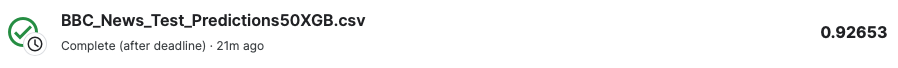

# Model Comparison and Discussion

In [ ]:
test_scores = {
    'Model': ['NMF', 'NMF tuned', 'NMF 50%', 'XGBoost', 'XGBoost tuned', 'XGBoost 50%'],
    'Training Accuracy': [0.9161, 0.9537, 0.8973, 1.0, 0.9846, 1.0],
    'Testing Accuracy': [0.9020, 0.8857, 0.9034, 0.9524, 0.8816, 0.9265]
}

df = pd.DataFrame(test_scores)
print(df)

           Model  Training Accuracy  Testing Accuracy
0            NMF             0.9161            0.9020
1      NMF tuned             0.9537            0.8857
2        NMF 50%             0.8973            0.9034
3        XGBoost             1.0000            0.9524
4  XGBoost tuned             0.9846            0.8816
5    XGBoost 50%             1.0000            0.9265


From the table above, we can see that for the NMF model, futher tuning the hyperparameters increases the training accuracy but this does not necessarily translate to an increase in testing accuracy. This shows that the tuned NMF has been overfitted. For the supervised XGBoost, tuning slightly decreases training accuracy and also dramatically decreases testing accuracy. Similarly, this proves that the tuning process has made the model ill-fitted. As a consquence, more research should be done to optimize this tuning process so as to avoid making the models perform worse.

When training the models on a reduced set of training data, the testing accuracy of the NMF model does not seem to change as much as the XGBoost. This proves that the NMF model is more data-efficient than the XGBoost. However, at the end the supervised XGBoost still performs the best in term of accuracy.